I am using [CatBoost](https://catboost.ai/) XGBoost classification algorithm for a prediction model for golf putts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_confusion_matrix

from sklearn.model_selection import train_test_split


plt.style.use("seaborn")

# CatBoost Training

In [2]:
# Load train, validation, and test sets
train = pd.read_pickle("../2_FeatureExtraction/data/train.pkl")
test = pd.read_pickle("../2_FeatureExtraction/data/test.pkl")

# Remove id
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)


train.head()

Distance  Result  AX_Range  AX_Max  AX_Min  AX_Last    AX_Mean  \
146         4       0      75.0    70.0    -5.0     70.0  27.625000   
117         4       1     123.0    82.0   -41.0     82.0  11.857143   
201         6       1     215.0   158.0   -57.0     58.0  60.000000   
156         5       1     203.0   111.0   -92.0     78.0  29.600000   
152         5       0     157.0   130.0   -27.0    130.0  29.200000   

      AX_StDev    AX_MeanD  AX_StDevDem  ...  Accel_Deriv  Gyro_Range  \
146  29.012659   32.625000    29.012659  ...     0.921864   76.668186   
117  37.869809   52.857143    37.869809  ...    -0.999936   70.940441   
201  68.600292  117.000000    68.600292  ...    -4.920998   51.266960   
156  71.795822  121.600000    71.795822  ...    -1.834295   78.538963   
152  60.713755   56.200000    60.713755  ...    -4.567292   60.445141   

       Gyro_Max    Gyro_Min   Gyro_Last   Gyro_Mean  Gyro_StDev  Gyro_MeanD  \
146  528.106997  451.438811  451.438811  488.331847   25.468255   36.893036   
117  509.959802  439.019362  439.019362  472.826563   28.538912   33.807202   
201  511.219131  459.952171  459.952171  486.863509   18.163799   26.911338   
156  514.269385  435.730421  435.730421  475.198878   26.728746   39.468457   
152  509.260248  448.815107  448.815107  482.307385   22.973597   33.492279   

     Gyro_StDevDem  Gyro_Deriv  
146      25.468255   -1.782981  
117      28.538912   -1.917309  
201      18.163799   -2.050678  
156      26.728746   -3.141559  
152      22.973597   -2.417806  

[5 rows x 74 columns]

This was an iterrative process of illiminating

In [3]:
# Remove AX
col_rem = [col for col in train if col.startswith(('Gyro', 'Accel', 'AX', 'GX'))]

train.drop(col_rem, axis=1, inplace=True)
test.drop(col_rem, axis=1, inplace=True)

In [4]:
train.shape

(175, 38)

In [5]:
test.shape

(75, 38)

CatBoost has a built-in hyperparameter tuning algorithm. I assign some of the obervations (30%) from the training set to a validation set for the hyperparameter tuning. 

In [6]:
# Create validation set
train_ds, val_ds  = train_test_split(train, test_size=0.3, random_state=123, stratify=train[['Result', 'Distance']])
print(train_ds.shape)
print(val_ds.shape)

# Prepare data
X_train = train_ds.drop('Result', axis=1)
X_val = val_ds.drop('Result', axis=1)

y_train = train_ds.Result
y_val = val_ds.Result


# Parameters
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 40
    
}


categorical_features_indices = []
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)


(122, 38)
(53, 38)


In [7]:
# Save the model
model.save_model("./data/catboost_model.cb")

# Model performance

We examine model performance in train, validation, and test dataset. 

First, let's examine model scores.

In [8]:
# Train data
tr_acc = model.score(Pool(X_train, y_train, cat_features=categorical_features_indices))
tr_acc

1.0

In [9]:
# Validation data
val_acc = model.score(Pool(X_val, y_val,cat_features=categorical_features_indices))
val_acc

0.7735849056603774

In [10]:
# Test data

test_data = test.drop('Result', axis=1)
test_labels = test.Result

test_acc = model.score(Pool(test_data, test_labels, cat_features=categorical_features_indices))
test_acc

0.64

The score is not particularly high, but still better than a coin toss. Next, we see if the predictions are biased by examining confusion matrices. 

In [11]:
def PlotConfusion(model, data, labels, cat_features,score):
    '''
    Helper function to plot confusion matrix
    '''
    
    cm = get_confusion_matrix(model, Pool(data, labels, cat_features=categorical_features_indices))
    
    cm_df = pd.DataFrame(cm,
                     index = ['Miss','Hit'], 
                     columns = ['Miss','Hit'])
    
    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('CatBoost \nAccuracy:{0:.3f}'.format(score))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

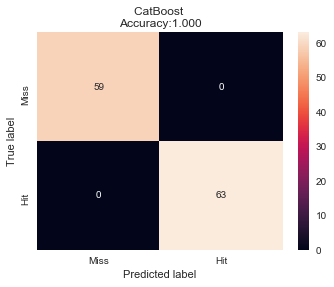

In [12]:
PlotConfusion(model,X_train, y_train, categorical_features_indices, tr_acc)



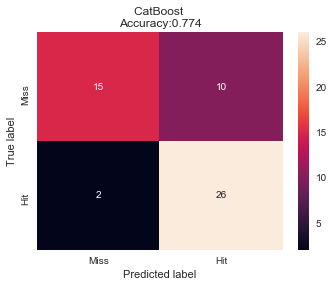

In [13]:
PlotConfusion(model, X_val, y_val, categorical_features_indices, val_acc)

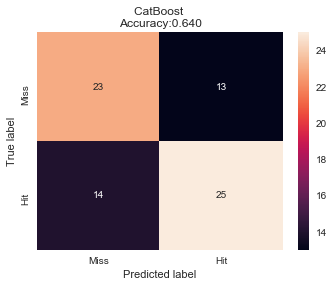

In [14]:
PlotConfusion(model, test_data, test_labels, categorical_features_indices, test_acc)

We see that the predictions do not seem to be extremely biased, maybe a bit towards successful hit. Probably, as a future work, we need collect more data and make data more granual to improve the accuracy. 

# Examine feature importance

Let's examine if feature importance assigned by the model makes practical sense.

In [15]:
feats = pd.DataFrame({"Feature":model.feature_names_, "Importance":model.feature_importances_})
feats.loc[feats.Importance!=0,:].sort_values('Importance', ascending=False)

Feature  Importance
25     GY_MeanD    6.356344
11       AZ_Max    6.042529
14      AZ_Mean    5.089385
32      GZ_Mean    4.419748
21       GY_Min    4.113567
4       AY_Last    3.765807
17  AZ_StDevDem    3.491760
19     GY_Range    3.255529
26  GY_StDevDem    3.219690
34     GZ_MeanD    3.205514
20       GY_Max    3.162079
5       AY_Mean    3.127159
12       AZ_Min    3.034305
6      AY_StDev    3.028266
9      AY_Deriv    2.933876
8   AY_StDevDem    2.827172
24     GY_StDev    2.820586
15     AZ_StDev    2.794011
31      GZ_Last    2.741478
36     GZ_Deriv    2.680522
18     AZ_Deriv    2.543299
23      GY_Mean    2.397385
2        AY_Max    2.360482
10     AZ_Range    2.220167
13      AZ_Last    2.191471
0      Distance    2.075451
3        AY_Min    1.999197
35  GZ_StDevDem    1.676074
7      AY_MeanD    1.647107
28     GZ_Range    1.576146
33     GZ_StDev    1.422165
30       GZ_Min    1.263877
16     AZ_MeanD    1.233731
1      AY_Range    1.206648
22      GY_Last    1.126194
27     GY_Deriv    0.764031
29       GZ_Max    0.187250

We plot 10 most important features

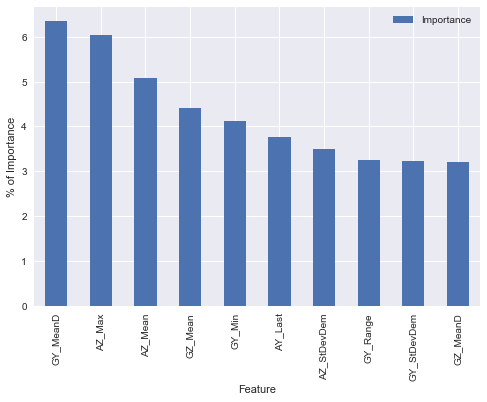

In [16]:
feats.loc[feats.Importance!=0,:].sort_values('Importance', ascending=False).set_index('Feature').\
iloc[0:10].plot(kind='bar')

_= plt.ylabel("% of Importance")

AY and AZ variables are very important, just as we saw on the data cleaning stage.